In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from dateutil.parser import parse
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report 
import unicodedata
import geopandas

from matplotlib import pyplot as plt

# Load the data

In [3]:
my_df= pd.read_pickle('cancer_data_cleaned.pkl')

my_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7556 entries, 3254875 to 1195415
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype    
---  ------            --------------  -----    
 0   Rank              7556 non-null   int64    
 1   Title             7556 non-null   object   
 2   Status            7556 non-null   int64    
 3   Study Results     7556 non-null   object   
 4   Conditions        7556 non-null   object   
 5   Interventions     7556 non-null   object   
 6   Outcome Measures  7556 non-null   object   
 7   Gender            7556 non-null   float64  
 8   Age               7556 non-null   object   
 9   Phases            7556 non-null   object   
 10  Enrollment        7556 non-null   float64  
 11  Start Date        7556 non-null   period[M]
 12  Completion Date   7556 non-null   period[M]
 13  Locations         7556 non-null   object   
 14  URL               7556 non-null   object   
 15  Actual            7556 non-null   float64  
 1

In [14]:
my_df['Phases'].unique()

array(['Not Applicable', 'Phase 1', 'Phase 2', 'Phase 1|Phase 2',
       'Phase 4', 'Phase 3', 'Phase 2|Phase 3', 'Early Phase 1'],
      dtype=object)

In [15]:
my_df['Phases'] = my_df['Phases'].replace('Not Applicable',np.NaN ) 

In [ ]:
phases_dict = 

# Logistic Regression 

In [4]:
X= my_df[['EFraction','Intervention', 'Months' , 'Age_Type', 'Gender' ]]

In [5]:
y=my_df['Status']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [7]:
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (5062, 5) (5062,)
Test (2494, 5) (2494,)


In [8]:
logmodel= LogisticRegression(class_weight='balanced')
logmodel.fit(X_train, y_train)
predictions_log= logmodel.predict(X_test)

In [9]:
print(classification_report(y_test, predictions_log))

              precision    recall  f1-score   support

           0       0.48      0.75      0.59       516
           1       0.92      0.79      0.85      1978

    accuracy                           0.78      2494
   macro avg       0.70      0.77      0.72      2494
weighted avg       0.83      0.78      0.80      2494



In [10]:
importance= logmodel.coef_.flatten()
importance

array([ 3.15371288,  0.05064296,  0.00790605,  0.05192451, -0.0527134 ])

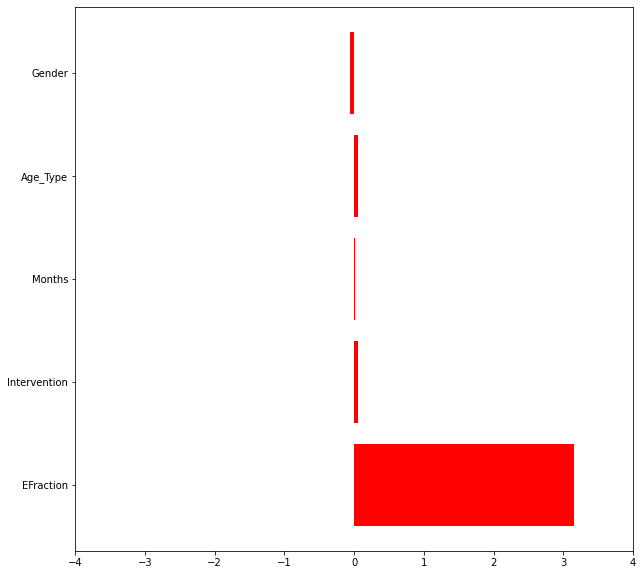

In [11]:
plt.rcParams["figure.figsize"]= (10,10)
plt.barh(X.columns, importance, color="r")
plt.xlim(-4,4)
plt.show()

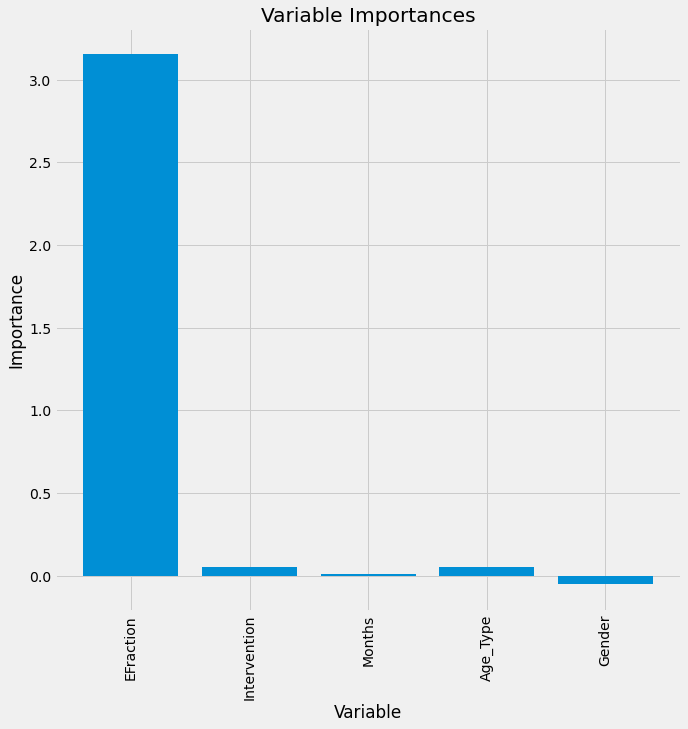

In [12]:
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importance)))
# Make a bar chart
plt.bar(x_values, importance, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values,list(X.columns) , rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [13]:
countries_df = my_df[['Countries','Status']].copy()


def countries(data):
    for i in data['Countries'] :
        i = i.strip()
    return i
countries_df['Countries']= countries_df.apply(countries, axis=1)

c_df= (countries_df.set_index('Status')['Countries'].explode().rename('Country').groupby(level=0).value_counts().reset_index(name='count'))

In [16]:
c_df['Country'] = np.where(
    c_df['Country'] == 'United States', 
    'United States of America', 
    c_df['Country']
)

In [88]:
c_df.head()

,Status,Country,count
0,0,United States of America,1023
1,0,France,72
2,0,United Kingdom,46
3,0,China,43
4,0,Germany,41


In [84]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# Merge the two DataFrames together
table = world.merge(c_df.loc[c_df['Status'] == 0], how="left", left_on=['name'], right_on=['Country'])

In [85]:
table.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Status,Country,count
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",NaN,NaN,NaN
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",NaN,NaN,NaN
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN,NaN
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",0.0,Canada,39.0
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",0.0,United States of America,1023.0


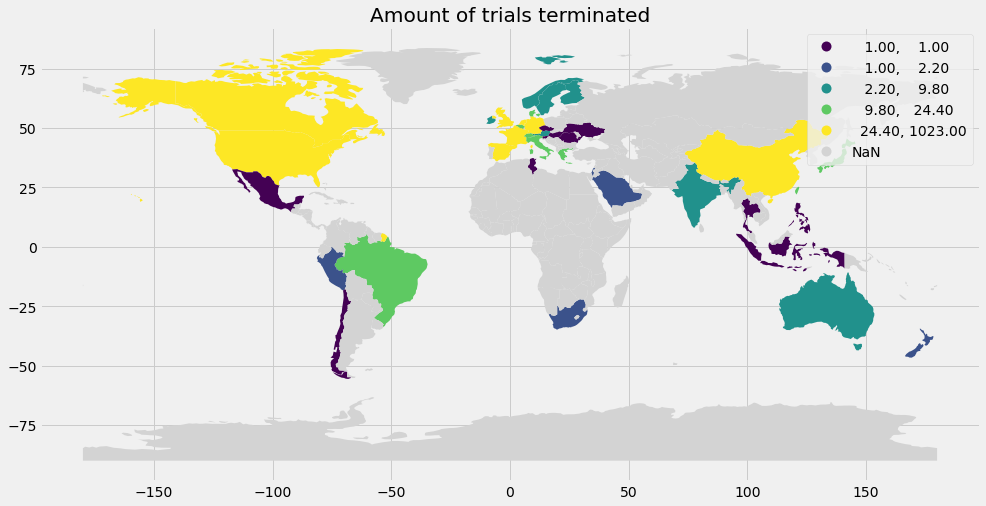

In [86]:
ax = table.plot(column='count', scheme="quantiles",
           figsize=(15,15),
           legend=True,cmap='viridis',  missing_kwds= dict(color = "lightgrey",))

ax.set_title("Amount of trials terminated")

## save fig
plt.savefig("terminated.png", dpi=200)

In [87]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=10, random_state=0)
regressor.fit(X_train, y_train)


RandomForestRegressor(n_estimators=10, random_state=0)

In [29]:
# Use the forest's predict method on the test data
predictions = regressor.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.22 degrees.


In [32]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [51]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = regressor.estimators_[5]

In [52]:
export_graphviz(tree, out_file = 'tree.dot', feature_names = list(X.columns), rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')


In [53]:
# Write graph to a png file
graph.write_png('tree.png')

In [48]:
list(X.columns)

['EFraction', 'Intervention', 'Months', 'Age_Type', 'Gender']

In [54]:
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(X_train, y_train)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = list(X.columns), rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png')

In [55]:
# Get numerical feature importances
importances = list(regressor.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(list(X.columns), importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: EFraction            Importance: 0.61
Variable: Months               Importance: 0.25
Variable: Intervention         Importance: 0.07
Variable: Gender               Importance: 0.05
Variable: Age_Type             Importance: 0.02


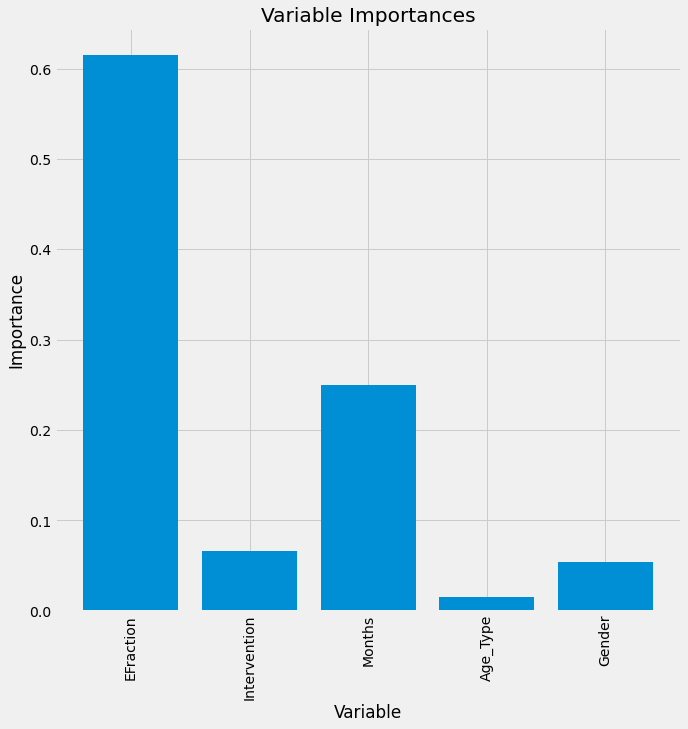

In [57]:
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values,list(X.columns) , rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [106]:
import torch as T
device = T.device("cpu")
x= my_df[['EFraction','Intervention', 'Months' , 'Age_Type', 'Gender' ]].values
y= my_df['Status'].values
print("shape of x: {}\nshape of y: {}".format(x.shape,y.shape))

shape of x: (7556, 5)
shape of y: (7556,)


In [107]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x = sc.fit_transform(x)

In [108]:
from torch.utils.data import Dataset, DataLoader

class dataset(Dataset):
    def __init__(self,x,y):
        self.x = T.tensor(x,dtype=T.float32)
        self.y = T.tensor(y,dtype=T.float32)
        self.length = self.x.shape[0]
 
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    
    def __len__(self):
        return self.length
    
trainset = dataset(x,y)
#DataLoader
trainloader = DataLoader(trainset,batch_size=64,shuffle=False)

In [111]:
#defining the network
from torch import nn
from torch.nn import functional as F
class Net(nn.Module):
    def __init__(self,input_shape):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_shape,32)
        self.fc2 = nn.Linear(32,64)
        self.fc3 = nn.Linear(64,1)
    def forward(self,x):
        x = T.relu(self.fc1(x))
        x = T.relu(self.fc2(x))
        x = T.sigmoid(self.fc3(x))
        return x

In [125]:
#hyper parameters
learning_rate = 0.01
epochs = 700
# Model , Optimizer, Loss
model = Net(input_shape=x.shape[1])
optimizer = T.optim.SGD(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()

In [126]:
#forward loop
losses = []
accur = []
for i in range(epochs):
    for j,(x_train,y_train) in enumerate(trainloader):
        #calculate outpuT
        output = model(x_train)
        #calculate loss
        loss = loss_fn(output,y_train.reshape(-1,1))
        #accuracy
        predicted = model(T.tensor(x,dtype=T.float32))
        acc = (predicted.reshape(-1).detach().numpy().round() == y).mean()
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if i%50 == 0:
        losses.append(loss)
        accur.append(acc)
        print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))


epoch 0	loss : 0.5740506052970886	 accuracy : 0.7977766013763896
epoch 50	loss : 0.3386654853820801	 accuracy : 0.8570672313393329
epoch 100	loss : 0.3011375367641449	 accuracy : 0.8611699311805188
epoch 150	loss : 0.274181991815567	 accuracy : 0.8618316569613552
epoch 200	loss : 0.2595004439353943	 accuracy : 0.8620963472736898
epoch 250	loss : 0.250532865524292	 accuracy : 0.8620963472736898
epoch 300	loss : 0.2408926635980606	 accuracy : 0.8622286924298571
epoch 350	loss : 0.23433449864387512	 accuracy : 0.863155108523028
epoch 400	loss : 0.22945833206176758	 accuracy : 0.8635521439915299
epoch 450	loss : 0.22729307413101196	 accuracy : 0.8638168343038645
epoch 500	loss : 0.22385308146476746	 accuracy : 0.8632874536791953
epoch 550	loss : 0.21973463892936707	 accuracy : 0.8628904182106935
epoch 600	loss : 0.2131824493408203	 accuracy : 0.8626257278983589
epoch 650	loss : 0.20678813755512238	 accuracy : 0.8624933827421917


In [127]:
losses

[tensor(0.5741, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.3387, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.3011, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.2742, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.2595, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.2505, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.2409, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.2343, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.2295, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.2273, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.2239, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.2197, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.2132, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.2068, grad_fn=<BinaryCrossEntropyBackward0>)]

Text(0, 0.5, 'loss')

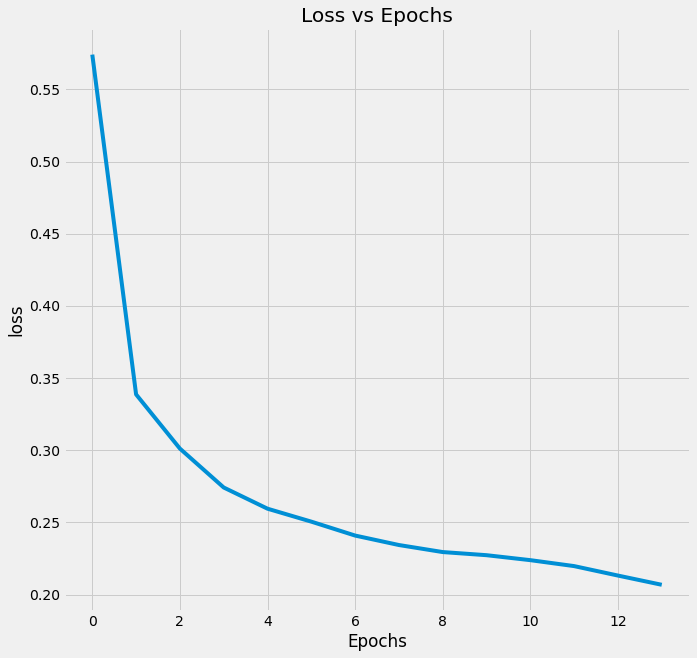

In [128]:
#plotting the loss

plt.plot(T.stack(losses).cpu().detach().numpy())
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')

Text(0, 0.5, 'loss')

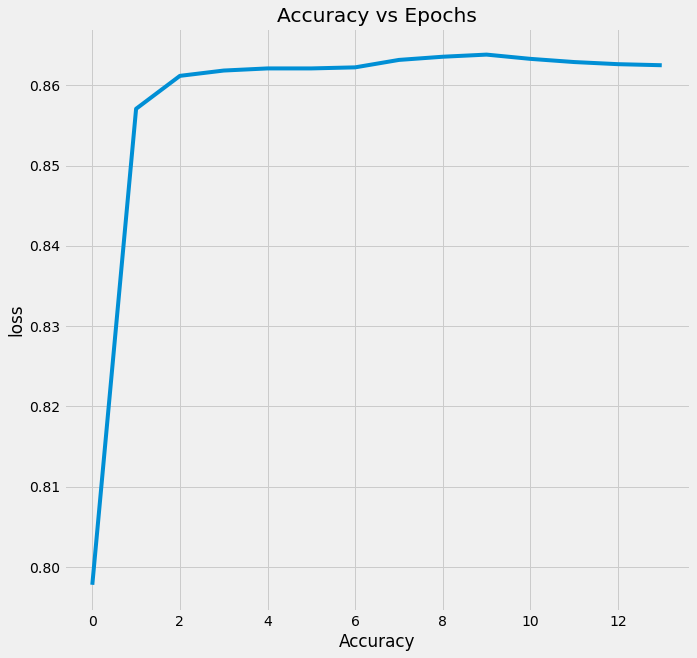

In [129]:
plt.plot(accur)
plt.title('Accuracy vs Epochs')
plt.xlabel('Accuracy')
plt.ylabel('loss')